# Instalaçoes e bibliotecas necessárias

In [1]:
!pip install unidecode openpyxl imbalanced-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.8/235.8 kB 3.6 MB/s eta 0:00:00


In [2]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
import pandas as pd
import re
import string
from unidecode import unidecode
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem.snowball import SnowballStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive
from imblearn.over_sampling import SMOTE

# Carregando dataset

In [4]:
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
df = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/MiniProjeto/dataset/CorpusTwitchVideojuegos.xlsx")
df = df[['TEXTO', 'Emociones']].dropna()
#alterar dataset:
#df = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/MiniProjeto/dataset/CorpusTwitchVideogames_Extension2024.xlsx")

# Função de pré-processamento

In [6]:
stop_words = set(stopwords.words('spanish'))
stemmer = SnowballStemmer('spanish')
tokenizer = TweetTokenizer()


In [7]:
def preprocess(text):
    text = str(text).lower()
    text = unidecode(text)
    text = re.sub(r'(.)\1{2,}', r'\1', text)
    text = re.sub(r'\b(j[aeiou]{1,})+\b', 'jaja', text)
    text = re.sub(r'\bx[o0]+\b', 'pero', text)
    text = re.sub(r'\bxfa\b', 'por favor', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#\w+', '', text)
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'\b(streamlabs|nightbot)\b', '', text)
    text = re.sub(r'\w*\d\w*', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))

    tokens = tokenizer.tokenize(text)
    tokens = [stemmer.stem(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

# Aplica o pré-processamento

In [8]:
df['clean_text'] = df['TEXTO'].apply(preprocess)

# Vetorização com TF-IDF e preparação de dados


In [9]:
y = df['Emociones']

In [10]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['clean_text'])

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Aplicando SMOTE

In [12]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

analisando distribuição

In [13]:
from collections import Counter
print("Antes do SMOTE:", Counter(y_train))
print("Depois do SMOTE:", Counter(y_train_resampled))

Antes do SMOTE: Counter({'Aprobación/Empatía/Confianza': 490, 'Desaprobación': 345, 'Indeterminado': 205, 'Decepción/Tristeza': 196, 'Interés/Anticipación/Hype': 185, 'Enfado/Ira': 129})
Depois do SMOTE: Counter({'Decepción/Tristeza': 490, 'Desaprobación': 490, 'Aprobación/Empatía/Confianza': 490, 'Enfado/Ira': 490, 'Indeterminado': 490, 'Interés/Anticipación/Hype': 490})


# Definindo modelos

In [14]:
rf_model = RandomForestClassifier(
    n_estimators=500, max_features='sqrt', random_state=42
)
rf_model.fit(X_train_resampled, y_train_resampled)

#PARAMETROS ARTIGO: n_estimators=500, max_features='sqrt'
#MEUS PARAMETROS: n_estimators: 100, max_features: 'log2

RandomForestClassifier(n_estimators=500, random_state=42)

In [15]:
svm_model = SVC(C=1000, kernel='rbf', random_state=42)
svm_model.fit(X_train_resampled, y_train_resampled)

#PARAMETROS ARTIGO: C=1000, kernel='rbf'
#MEUS PARAMETROS: C=1, kernel='linear'

SVC(C=1000, random_state=42)

# Realizando predições

In [16]:
rf_pred = rf_model.predict(X_test)

In [17]:
svm_pred = svm_model.predict(X_test)

# Resultados

***relatórios de classificação***

In [18]:
print("\nCLASSIFICAÇÃO RANDOM FOREST")
print(classification_report(y_test, rf_pred))

print("\nCLASSIFICAÇÃO SVM")
print(classification_report(y_test, svm_pred))


CLASSIFICAÇÃO RANDOM FOREST
                              precision    recall  f1-score   support

Aprobación/Empatía/Confianza       0.67      0.50      0.57       221
          Decepción/Tristeza       0.37      0.80      0.51        75
               Desaprobación       0.47      0.44      0.45       137
                  Enfado/Ira       0.38      0.46      0.42        39
               Indeterminado       0.40      0.29      0.34       110
   Interés/Anticipación/Hype       0.57      0.57      0.57        83

                    accuracy                           0.49       665
                   macro avg       0.48      0.51      0.48       665
                weighted avg       0.52      0.49      0.49       665


CLASSIFICAÇÃO SVM
                              precision    recall  f1-score   support

Aprobación/Empatía/Confianza       0.46      0.80      0.58       221
          Decepción/Tristeza       0.58      0.39      0.46        75
               Desaprobación       0.4

***F1-score***

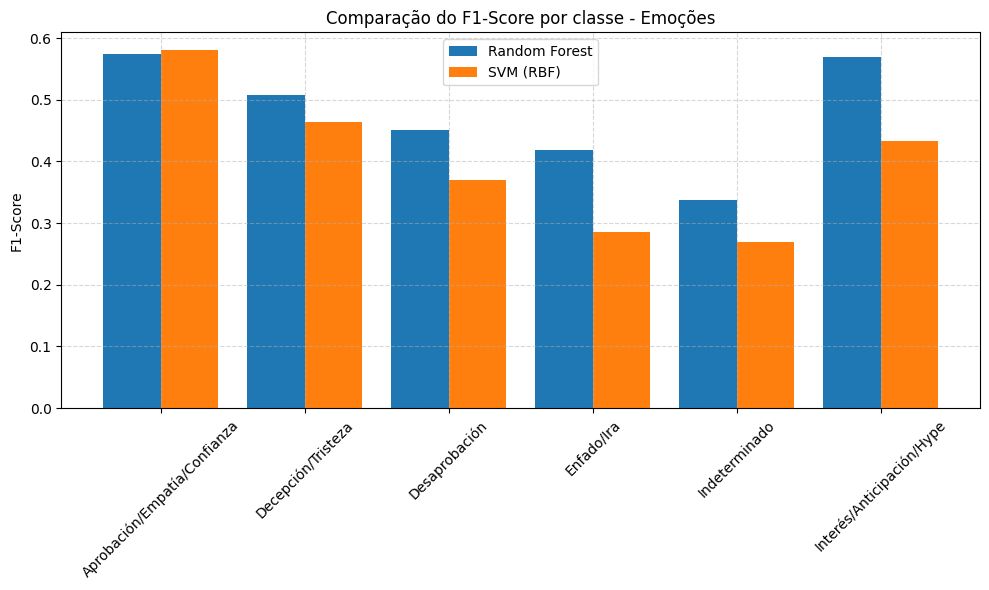

In [19]:
classes = sorted(y.unique())
f1_rf = f1_score(y_test, rf_pred, average=None, labels=classes)
f1_svm = f1_score(y_test, svm_pred, average=None, labels=classes)

x = range(len(classes))
plt.figure(figsize=(10, 6))
plt.bar(x, f1_rf, width=0.4, label='Random Forest', align='center')
plt.bar([i + 0.4 for i in x], f1_svm, width=0.4, label='SVM (RBF)', align='center')
plt.xticks([i + 0.2 for i in x], classes, rotation=45)
plt.ylabel('F1-Score')
plt.title('Comparação do F1-Score por classe - Emoções')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

Matrizes de confusão

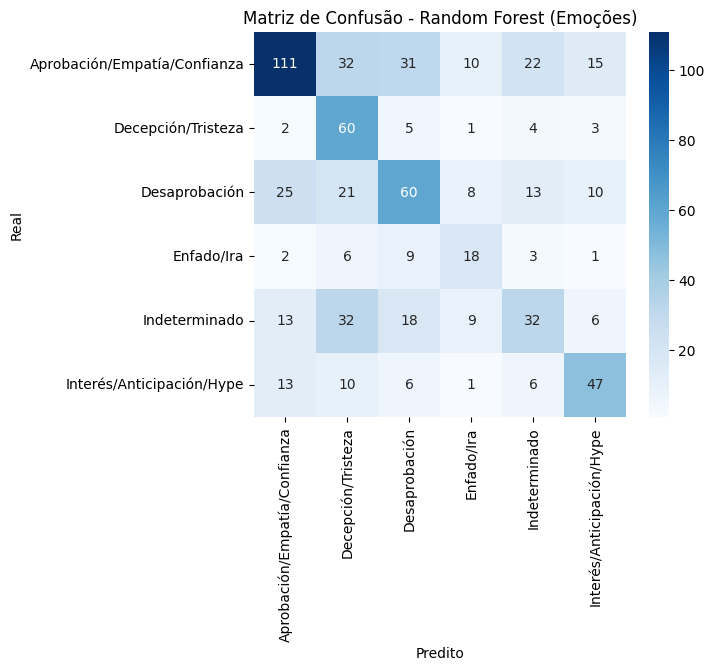

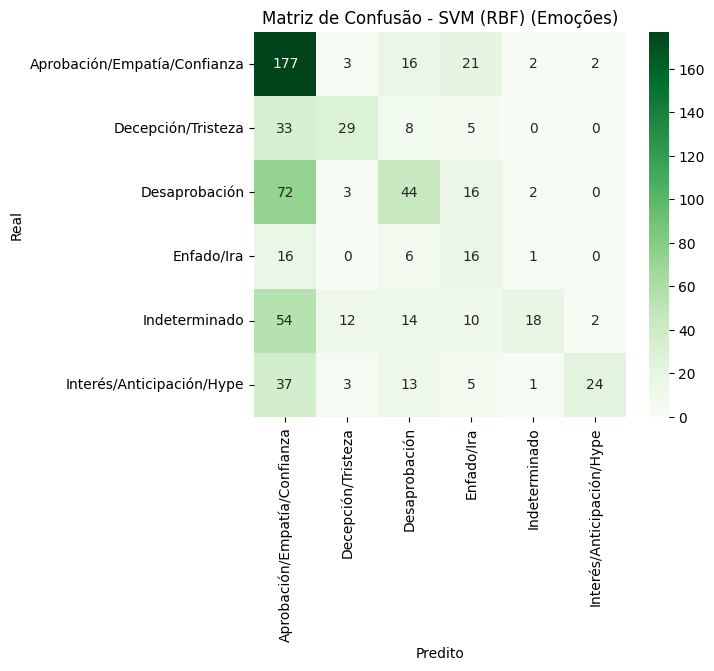

In [20]:
cm_rf = confusion_matrix(y_test, rf_pred, labels=classes)
cm_svm = confusion_matrix(y_test, svm_pred, labels=classes)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Matriz de Confusão - Random Forest (Emoções)')
plt.xlabel('Predito')
plt.ylabel('Real')
plt.show()

plt.figure(figsize=(6, 5))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Greens', xticklabels=classes, yticklabels=classes)
plt.title('Matriz de Confusão - SVM (RBF) (Emoções)')
plt.xlabel('Predito')
plt.ylabel('Real')
plt.show()